GENERATING SYNTHETIC BEVERAGE SHELF LIFE DATA

Dataset created with 2000 samples

Dataset Overview:
   Temperature_C  Humidity_Percent  Light_Exposure_Hours Packaging_Type  \
0      17.483444         45.702341              6.863951       Aluminum   
1      38.225715         44.818728              9.665188          Glass   
2      30.351782         84.375275              9.121931     Tetra_Pack   
3      25.551705         44.972772              1.846799       Aluminum   
4       9.616671         46.316984              1.790994          Glass   

   Product_Type  Oxygen_Permeability  Shelf_Life_Days  
0  Energy_Drink             0.074728       565.673264  
1         Juice             0.033291       130.004098  
2          Beer             0.170462       180.296506  
3         Water             0.121453       490.224380  
4         Juice             0.047662       641.256800  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 co

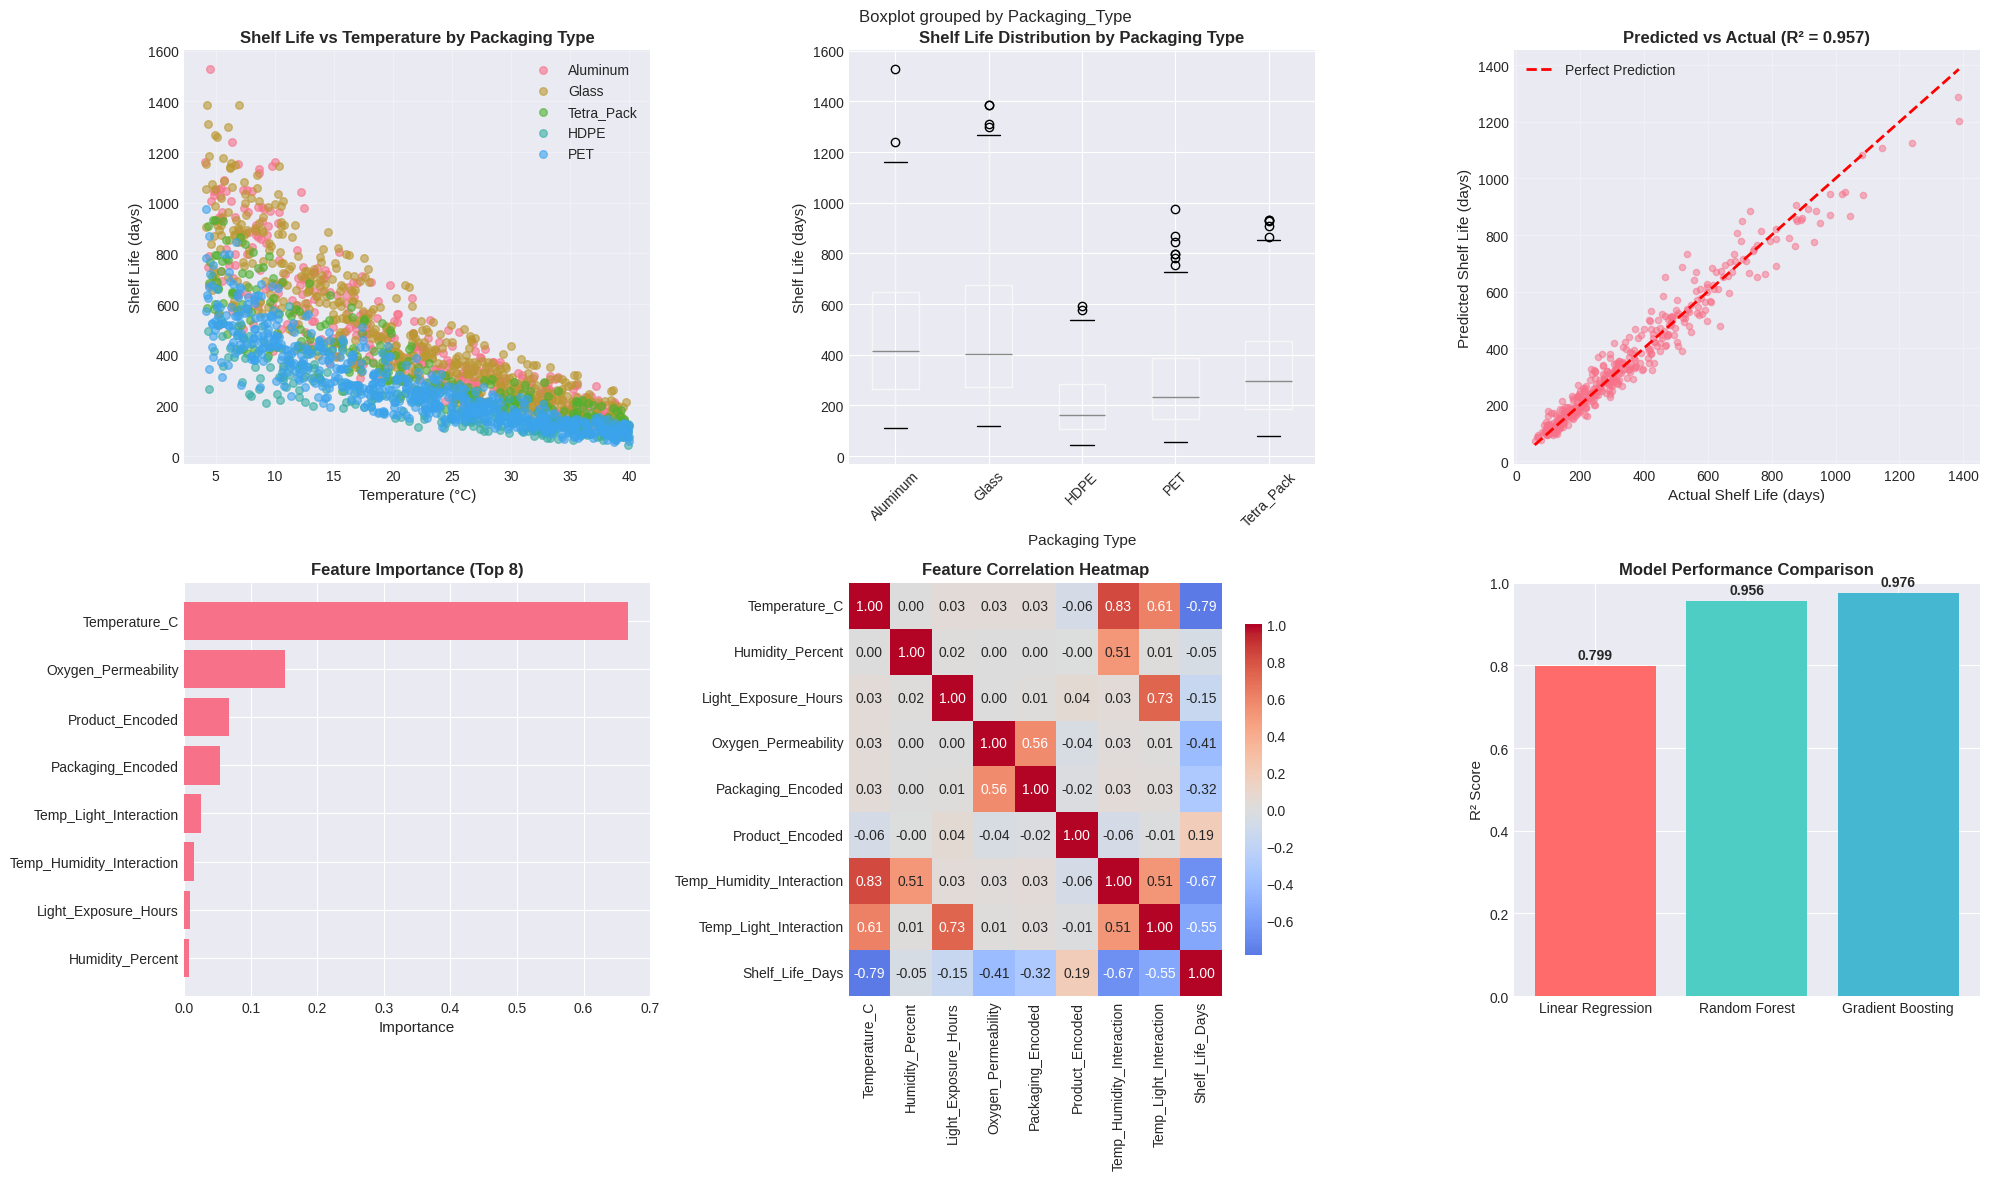


KEY INSIGHTS & RECOMMENDATIONS

1. PACKAGING PERFORMANCE:
----------------------------------------
                      mean         std         min          max
Packaging_Type                                                 
Glass           487.129164  271.688685  120.500220  1385.910016
Aluminum        479.931711  271.919726  109.803248  1526.978375
Tetra_Pack      348.358581  204.150820   80.185778   931.694163
PET             277.798680  163.499141   55.265328   977.052622
HDPE            210.568644  124.867735   44.002276   591.068983

2. OPTIMAL STORAGE CONDITIONS (Top 10% Shelf Life):
----------------------------------------
   Temperature: 8.1 ± 3.1 °C
   Humidity: 58.7 ± 17.4 %
   Light Exposure: 4.9 ± 3.6 hours/day

3. RECOMMENDATIONS:
----------------------------------------
   • Glass and Aluminum packaging provide the longest shelf life
   • Maintain storage temperature below 25°C for optimal preservation
   • Keep humidity levels between 40-60% to prevent degradation
  

In [1]:
"""
Shelf Life Prediction Model for Packaged Beverages
===================================================
This model predicts the shelf life of packaged beverages based on storage conditions
and packaging materials using machine learning techniques.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==================== STEP 1: DATA GENERATION ====================
def generate_synthetic_data(n_samples=2000):
    """
    Generate synthetic beverage shelf life data based on known industry trends
    """
    np.random.seed(42)

    # Storage conditions
    temperature = np.random.uniform(4, 40, n_samples)  # 4°C to 40°C
    humidity = np.random.uniform(30, 90, n_samples)    # 30% to 90% RH
    light_exposure = np.random.uniform(0, 12, n_samples)  # 0 to 12 hours/day

    # Packaging types with different probabilities
    packaging_types = np.random.choice(
        ['Glass', 'PET', 'Aluminum', 'Tetra_Pack', 'HDPE'],
        n_samples,
        p=[0.25, 0.30, 0.20, 0.15, 0.10]
    )

    # Product types
    product_types = np.random.choice(
        ['Beer', 'Soft_Drink', 'Juice', 'Energy_Drink', 'Water'],
        n_samples,
        p=[0.25, 0.25, 0.20, 0.15, 0.15]
    )

    # Oxygen permeability (simulated based on packaging)
    oxygen_perm = []
    for pkg in packaging_types:
        if pkg == 'Glass':
            oxygen_perm.append(np.random.uniform(0, 0.1))
        elif pkg == 'Aluminum':
            oxygen_perm.append(np.random.uniform(0, 0.2))
        elif pkg == 'Tetra_Pack':
            oxygen_perm.append(np.random.uniform(0.1, 0.5))
        elif pkg == 'PET':
            oxygen_perm.append(np.random.uniform(0.3, 1.0))
        else:  # HDPE
            oxygen_perm.append(np.random.uniform(0.5, 1.2))

    # Calculate shelf life based on complex interactions
    shelf_life = []
    for i in range(n_samples):
        # Base shelf life
        base_life = 365  # days

        # Temperature effect (Arrhenius-like relationship)
        temp_factor = np.exp(-0.05 * (temperature[i] - 25))

        # Humidity effect
        humidity_factor = 1 - 0.002 * (humidity[i] - 50)

        # Light exposure effect
        light_factor = 1 - 0.02 * light_exposure[i]

        # Packaging material factor
        pkg_factors = {
            'Glass': 1.2,
            'Aluminum': 1.15,
            'Tetra_Pack': 0.95,
            'PET': 0.85,
            'HDPE': 0.75
        }
        pkg_factor = pkg_factors[packaging_types[i]]

        # Product type factor
        product_factors = {
            'Beer': 0.9,
            'Soft_Drink': 1.0,
            'Juice': 0.7,
            'Energy_Drink': 1.1,
            'Water': 1.3
        }
        product_factor = product_factors[product_types[i]]

        # Oxygen permeability effect
        oxygen_factor = 1 - 0.3 * oxygen_perm[i]

        # Calculate final shelf life with some noise
        life = (base_life * temp_factor * humidity_factor * light_factor *
                pkg_factor * product_factor * oxygen_factor)
        life = max(7, life + np.random.normal(0, 10))  # Add noise, minimum 7 days
        shelf_life.append(life)

    # Create DataFrame
    data = pd.DataFrame({
        'Temperature_C': temperature,
        'Humidity_Percent': humidity,
        'Light_Exposure_Hours': light_exposure,
        'Packaging_Type': packaging_types,
        'Product_Type': product_types,
        'Oxygen_Permeability': oxygen_perm,
        'Shelf_Life_Days': shelf_life
    })

    return data

# Generate the dataset
print("="*60)
print("GENERATING SYNTHETIC BEVERAGE SHELF LIFE DATA")
print("="*60)
df = generate_synthetic_data(2000)
print(f"\nDataset created with {len(df)} samples")
print("\nDataset Overview:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

# ==================== STEP 2: DATA PREPROCESSING ====================
print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

# Create a copy for preprocessing
df_processed = df.copy()

# Encode categorical variables
le_packaging = LabelEncoder()
le_product = LabelEncoder()
df_processed['Packaging_Encoded'] = le_packaging.fit_transform(df_processed['Packaging_Type'])
df_processed['Product_Encoded'] = le_product.fit_transform(df_processed['Product_Type'])

# Feature engineering: Create interaction features
df_processed['Temp_Humidity_Interaction'] = df_processed['Temperature_C'] * df_processed['Humidity_Percent'] / 100
df_processed['Temp_Light_Interaction'] = df_processed['Temperature_C'] * df_processed['Light_Exposure_Hours'] / 10

# Select features for modeling
feature_columns = ['Temperature_C', 'Humidity_Percent', 'Light_Exposure_Hours',
                   'Oxygen_Permeability', 'Packaging_Encoded', 'Product_Encoded',
                   'Temp_Humidity_Interaction', 'Temp_Light_Interaction']
X = df_processed[feature_columns]
y = df_processed['Shelf_Life_Days']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# ==================== STEP 3: MODEL BUILDING ====================
print("\n" + "="*60)
print("MODEL TRAINING AND EVALUATION")
print("="*60)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5,
                                scoring='r2', n_jobs=-1)

    results[name] = {
        'R2_Score': r2,
        'RMSE': rmse,
        'MAE': mae,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std()
    }

    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f} days")
    print(f"  MAE: {mae:.2f} days")
    print(f"  Cross-Val R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Display results comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
results_df = pd.DataFrame(results).T
print(results_df)

# ==================== STEP 4: HYPERPARAMETER TUNING ====================
print("\n" + "="*60)
print("HYPERPARAMETER TUNING (Random Forest)")
print("="*60)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R² Score: {grid_search.best_score_:.4f}")

# Best model predictions
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)
best_r2 = r2_score(y_test, y_pred_best)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"\nBest Model Test Performance:")
print(f"  R² Score: {best_r2:.4f}")
print(f"  RMSE: {best_rmse:.2f} days")

# ==================== STEP 5: FEATURE IMPORTANCE ====================
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from the best Random Forest model
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

# ==================== STEP 6: VISUALIZATION ====================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# Create a figure with subplots
fig = plt.figure(figsize=(20, 12))

# 1. Shelf Life vs Temperature for different packaging types
ax1 = plt.subplot(2, 3, 1)
for pkg_type in df['Packaging_Type'].unique():
    mask = df['Packaging_Type'] == pkg_type
    ax1.scatter(df[mask]['Temperature_C'], df[mask]['Shelf_Life_Days'],
               label=pkg_type, alpha=0.6, s=30)
ax1.set_xlabel('Temperature (°C)', fontsize=11)
ax1.set_ylabel('Shelf Life (days)', fontsize=11)
ax1.set_title('Shelf Life vs Temperature by Packaging Type', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Boxplot for different packaging types
ax2 = plt.subplot(2, 3, 2)
df.boxplot(column='Shelf_Life_Days', by='Packaging_Type', ax=ax2)
ax2.set_xlabel('Packaging Type', fontsize=11)
ax2.set_ylabel('Shelf Life (days)', fontsize=11)
ax2.set_title('Shelf Life Distribution by Packaging Type', fontsize=12, fontweight='bold')
plt.sca(ax2)
plt.xticks(rotation=45)

# 3. Predicted vs Actual (Best Model)
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(y_test, y_pred_best, alpha=0.5, s=20)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Shelf Life (days)', fontsize=11)
ax3.set_ylabel('Predicted Shelf Life (days)', fontsize=11)
ax3.set_title(f'Predicted vs Actual (R² = {best_r2:.3f})', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature Importance
ax4 = plt.subplot(2, 3, 4)
ax4.barh(feature_importance['Feature'][:8], feature_importance['Importance'][:8])
ax4.set_xlabel('Importance', fontsize=11)
ax4.set_title('Feature Importance (Top 8)', fontsize=12, fontweight='bold')
ax4.invert_yaxis()

# 5. Heatmap of correlations
ax5 = plt.subplot(2, 3, 5)
correlation_matrix = df_processed[feature_columns + ['Shelf_Life_Days']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax5, cbar_kws={'shrink': 0.8})
ax5.set_title('Feature Correlation Heatmap', fontsize=12, fontweight='bold')

# 6. Model Performance Comparison
ax6 = plt.subplot(2, 3, 6)
models_names = list(results.keys())
r2_scores = [results[m]['R2_Score'] for m in models_names]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax6.bar(models_names, r2_scores, color=colors)
ax6.set_ylabel('R² Score', fontsize=11)
ax6.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax6.set_ylim([0, 1])
for bar, score in zip(bars, r2_scores):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('shelf_life_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== STEP 7: INSIGHTS & RECOMMENDATIONS ====================
print("\n" + "="*60)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*60)

# Analyze packaging performance
packaging_stats = df.groupby('Packaging_Type')['Shelf_Life_Days'].agg(['mean', 'std', 'min', 'max'])
packaging_stats = packaging_stats.sort_values('mean', ascending=False)

print("\n1. PACKAGING PERFORMANCE:")
print("-" * 40)
print(packaging_stats)

# Optimal storage conditions
optimal_conditions = df[df['Shelf_Life_Days'] > df['Shelf_Life_Days'].quantile(0.9)]
print("\n2. OPTIMAL STORAGE CONDITIONS (Top 10% Shelf Life):")
print("-" * 40)
print(f"   Temperature: {optimal_conditions['Temperature_C'].mean():.1f} ± {optimal_conditions['Temperature_C'].std():.1f} °C")
print(f"   Humidity: {optimal_conditions['Humidity_Percent'].mean():.1f} ± {optimal_conditions['Humidity_Percent'].std():.1f} %")
print(f"   Light Exposure: {optimal_conditions['Light_Exposure_Hours'].mean():.1f} ± {optimal_conditions['Light_Exposure_Hours'].std():.1f} hours/day")

print("\n3. RECOMMENDATIONS:")
print("-" * 40)
print("   • Glass and Aluminum packaging provide the longest shelf life")
print("   • Maintain storage temperature below 25°C for optimal preservation")
print("   • Keep humidity levels between 40-60% to prevent degradation")
print("   • Minimize light exposure, especially for PET packaging")
print("   • Consider product-specific requirements when selecting packaging")

# ==================== STEP 8: PREDICTIVE FUNCTION ====================
def predict_shelf_life(temperature, humidity, light_hours, packaging_type,
                       product_type='Soft_Drink', oxygen_perm=None):
    """
    Predict shelf life for given conditions

    Parameters:
    -----------
    temperature: float, Storage temperature in Celsius
    humidity: float, Relative humidity percentage
    light_hours: float, Daily light exposure in hours
    packaging_type: str, One of ['Glass', 'PET', 'Aluminum', 'Tetra_Pack', 'HDPE']
    product_type: str, One of ['Beer', 'Soft_Drink', 'Juice', 'Energy_Drink', 'Water']
    oxygen_perm: float, Oxygen permeability (optional, will be estimated if None)

    Returns:
    --------
    float: Predicted shelf life in days
    """

    # Estimate oxygen permeability if not provided
    if oxygen_perm is None:
        oxygen_perm_map = {
            'Glass': 0.05,
            'Aluminum': 0.1,
            'Tetra_Pack': 0.3,
            'PET': 0.65,
            'HDPE': 0.85
        }
        oxygen_perm = oxygen_perm_map.get(packaging_type, 0.5)

    # Encode categorical variables
    packaging_encoded = le_packaging.transform([packaging_type])[0]
    product_encoded = le_product.transform([product_type])[0]

    # Create interaction features
    temp_humidity_int = temperature * humidity / 100
    temp_light_int = temperature * light_hours / 10

    # Prepare input
    input_data = np.array([[temperature, humidity, light_hours, oxygen_perm,
                           packaging_encoded, product_encoded,
                           temp_humidity_int, temp_light_int]])

    # Scale the input
    input_scaled = scaler.transform(input_data)

    # Make prediction
    prediction = best_model.predict(input_scaled)[0]

    return max(7, prediction)  # Minimum 7 days

# Example predictions
print("\n" + "="*60)
print("EXAMPLE PREDICTIONS")
print("="*60)

test_cases = [
    (20, 50, 2, 'Glass', 'Beer'),
    (30, 70, 8, 'PET', 'Juice'),
    (15, 40, 0, 'Aluminum', 'Soft_Drink'),
    (35, 80, 10, 'HDPE', 'Water')
]

for temp, humid, light, pkg, prod in test_cases:
    pred_life = predict_shelf_life(temp, humid, light, pkg, prod)
    print(f"\nConditions: {temp}°C, {humid}% RH, {light}h light/day")
    print(f"Packaging: {pkg}, Product: {prod}")
    print(f"Predicted Shelf Life: {pred_life:.0f} days")

print("\n" + "="*60)
print("MODEL DEVELOPMENT COMPLETE!")
print("="*60)
print(f"\nFinal Model Performance:")
print(f"  • R² Score: {best_r2:.4f}")
print(f"  • RMSE: {best_rmse:.2f} days")
print(f"  • Model Type: Optimized Random Forest Regressor")
print(f"  • Training Samples: {len(X_train)}")
print(f"  • Test Samples: {len(X_test)}")

# Save the model and preprocessors
import joblib

print("\nSaving model artifacts...")
joblib.dump(best_model, 'shelf_life_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_packaging, 'packaging_encoder.pkl')
joblib.dump(le_product, 'product_encoder.pkl')
print("Model saved successfully!")

print("\nProject deliverables created:")
print("  1. Trained predictive model (shelf_life_model.pkl)")
print("  2. Comprehensive analysis visualizations (shelf_life_analysis.png)")
print("  3. Feature importance analysis")
print("  4. Storage optimization recommendations")
print("  5. Ready-to-use prediction function")